In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import os
import json, ast
import math

In [2]:
df_list = []
for file in os.listdir('data/'):
    temp_df = pd.read_csv('data/'+file)
    temp_df['p_id'] = int(file[:3])
    df_list.append(temp_df)
df = pd.concat(df_list).reset_index().drop('index', axis = 1)

In [3]:
df

,target_x,target_y,repeat_instructions.thisRepN,repeat_instructions.thisTrialN,repeat_instructions.thisN,repeat_instructions.thisIndex,accuracy_instructions.thisRepN,accuracy_instructions.thisTrialN,accuracy_instructions.thisN,accuracy_instructions.thisIndex,...,instr_adv_mouse_3_spd.x,instr_adv_mouse_3_spd.y,instr_adv_mouse_3_spd.leftButton,instr_adv_mouse_3_spd.midButton,instr_adv_mouse_3_spd.rightButton,instr_adv_mouse_3_spd.time,phase_cntdown.stopped,Unnamed: 281,repeat_instr_repeat.rt,Unnamed: 282
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46031,-0.3,0.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def find_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  for v1, v2 in zip(ab, ac):
    dotprod = np.dot(v1, v2)
    ab_magnitudes = np.linalg.norm(v1)
    ac_magnitudes = np.linalg.norm(v2)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
    angles.append(np.arccos(dotprod / (ab_magnitudes * ac_magnitudes)))
    

  return np.nanmean(angles)

In [5]:
def comp_avg_ang_error(traj):
    try:
        end_point = np.tile(traj[-1], len(traj) - 1).reshape((len(traj) - 1, 2))
        curr_point = np.array(traj[:-1])
        next_point = np.array(traj[1:])
        
        angles = find_angles(curr_point, end_point, next_point)
        return angles
    except:
        return np.NaN

In [31]:
def comp_init_ang_error(traj, proportion=0.1):
    cutoff_dist = proportion*np.sqrt(0.3**2 + 0.3**2)

    try:
        for cutoff_point in traj:
            euclid_dist = np.sqrt(cutoff_point[0]**2 + cutoff_point[1]**2)
            if euclid_dist > cutoff_dist:
                break
    except:
        return np.NaN
    try:
        end_point = traj[-1]
        v1 = end_point - np.array([0, 0])
        v2 = cutoff_point - np.array([0, 0])

        dotprod = np.dot(v1, v2)
        v1_magnitudes = np.linalg.norm(v1)
        v2_magnitudes = np.linalg.norm(v2)
        cross_prod = np.cross(v1, v2)
        if cross_prod < 0:
            sign = 1
        else:
            sign = -1
        return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
    except:
        return np.NaN

In [32]:
def compute_errors(file, error_func):
    df_relearn = pd.read_csv(file)
    errors = []
    if error_func == 'init':
        func = comp_init_ang_error
    else:
        func = comp_avg_ang_error
    
    if type(df_relearn['cursor trajectory'].values[0]) == str:
        # if df_relearn['cursor trajectory'].values[0].contains('array'):
        for traj in df_relearn['cursor trajectory'].values:
        # print(type(traj))
            errors.append(func(ast.literal_eval(traj.replace('array', ''))))
        # else:

        #     for traj in df_relearn['cursor trajectory'].values:
        #         # print(type(traj))
        #         errors.append(func(ast.literal_eval(traj)))
    else:
        for traj in df_relearn['cursor trajectory'].values:
            # print(traj)
            errors.append(func(traj))

    if error_func == 'init':
        df_relearn['init signed errors'] = errors
    else:
        df_relearn['avg errors'] = errors

    num_participants = 62
    num_blocktrials = 64
    num_blocks = len(df_relearn)/(num_participants*num_blocktrials)

    df_relearn['trial'] = np.tile(np.arange(num_blocktrials*num_blocks), num_participants)
    df_relearn['block'] = np.tile(np.repeat(np.arange(num_blocks), num_blocktrials), num_participants)
    df_relearn.loc[df_relearn['p_id']%2 == 0, 'Rotation'] = 'Sudden'
    df_relearn.loc[df_relearn['p_id']%2 == 1, 'Rotation'] = 'Gradual'

    df_relearn.loc[df_relearn['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
    df_relearn.loc[df_relearn['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
    df_relearn.loc[df_relearn['p_id']%4 == 2, 'Emphasis'] = 'Speed'
    df_relearn.loc[df_relearn['p_id']%4 == 3, 'Emphasis'] = 'Speed'
    df_relearn.to_csv(file, index=False)
    return df_relearn

In [36]:
df_relearn = compute_errors('df_learn.csv', 'init')

C:\Users\tejas\AppData\Local\Temp\ipykernel_22564\3007452606.py:24: RuntimeWarning: invalid value encountered in double_scalars
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))
C:\Users\tejas\AppData\Local\Temp\ipykernel_22564\3007452606.py:24: RuntimeWarning: invalid value encountered in arccos
  return sign*np.arccos(dotprod / (v1_magnitudes * v2_magnitudes))


In [33]:
# df_baseline = compute_errors('df_baseline.csv', 'avg')

In [37]:
df_baseline = pd.read_csv('df_baseline.csv')
df_learn = pd.read_csv('df_learn.csv')
df_unlearn = pd.read_csv('df_unlearn.csv')
df_relearn = pd.read_csv('df_relearn.csv')

df_baseline['phase'] = 'Baseline'
df_learn['phase'] = 'Learning'
df_unlearn['phase'] = 'Unlearning'
df_relearn['phase'] = 'Relearning'

In [38]:
df_allphases = pd.concat([df_baseline, df_learn, df_unlearn, df_relearn]).reset_index().drop(['cursor trajectory', 'index'], axis = 1)

In [39]:
df_allphases

,target_x,target_y,p_id,avg errors,trial,block,Rotation,Emphasis,init errors,phase,init signed errors
0,0.3,-0.3,641,NaN,0.0,0.0,Gradual,Accuracy,0.415961,Baseline,0.415961
1,-0.3,0.3,641,NaN,1.0,0.0,Gradual,Accuracy,0.131428,Baseline,0.131428
2,0.3,-0.3,641,NaN,2.0,0.0,Gradual,Accuracy,0.206181,Baseline,0.206181
3,0.3,-0.3,641,NaN,3.0,0.0,Gradual,Accuracy,0.206181,Baseline,NaN
4,-0.3,0.3,641,NaN,4.0,0.0,Gradual,Accuracy,0.495885,Baseline,-0.495885
...,...,...,...,...,...,...,...,...,...,...,...
43643,0.3,-0.3,702,0.402465,123.0,1.0,Sudden,Speed,1.203681,Relearning,-1.203681
43644,0.3,0.3,702,0.827459,124.0,1.0,Sudden,Speed,0.704598,Relearning,0.704598
43645,0.3,0.3,702,0.827459,125.0,1.0,Sudden,Speed,0.704598,Relearning,NaN
43646,-0.3,-0.3,702,0.715479,126.0,1.0,Sudden,Speed,1.933589,Relearning,1.933589


In [40]:
df_allphases['trial no'] = np.concatenate([np.tile(np.arange(64), 62), np.tile(np.arange(64*1, 64*8), 62), np.tile(np.arange(64*8, 64*9), 62), np.tile(np.arange(64*9, 64*11), 62)])
df_allphases['block no'] = np.concatenate([np.tile(np.repeat(1, 64), 62), np.tile(np.repeat(np.arange(1, 8), 64), 62), np.tile(np.repeat(8, 64), 62), np.tile(np.repeat([9, 10], 64), 62)])


In [49]:
df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'avg errors'] = -df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'avg errors']
df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'init errors'] = -df_allphases.loc[df_allphases['phase'] == 'Unlearning', 'init errors']

In [51]:
df_allphases.to_csv('df_allphases.csv', index = False)

In [5]:
df_allphases = pd.read_csv('df_allphases.csv')
df_allphases['init signed errors degrees'] = df_allphases['init signed errors']*180/np.pi
df_allphases['init errors degrees'] = df_allphases['init errors']*180/np.pi


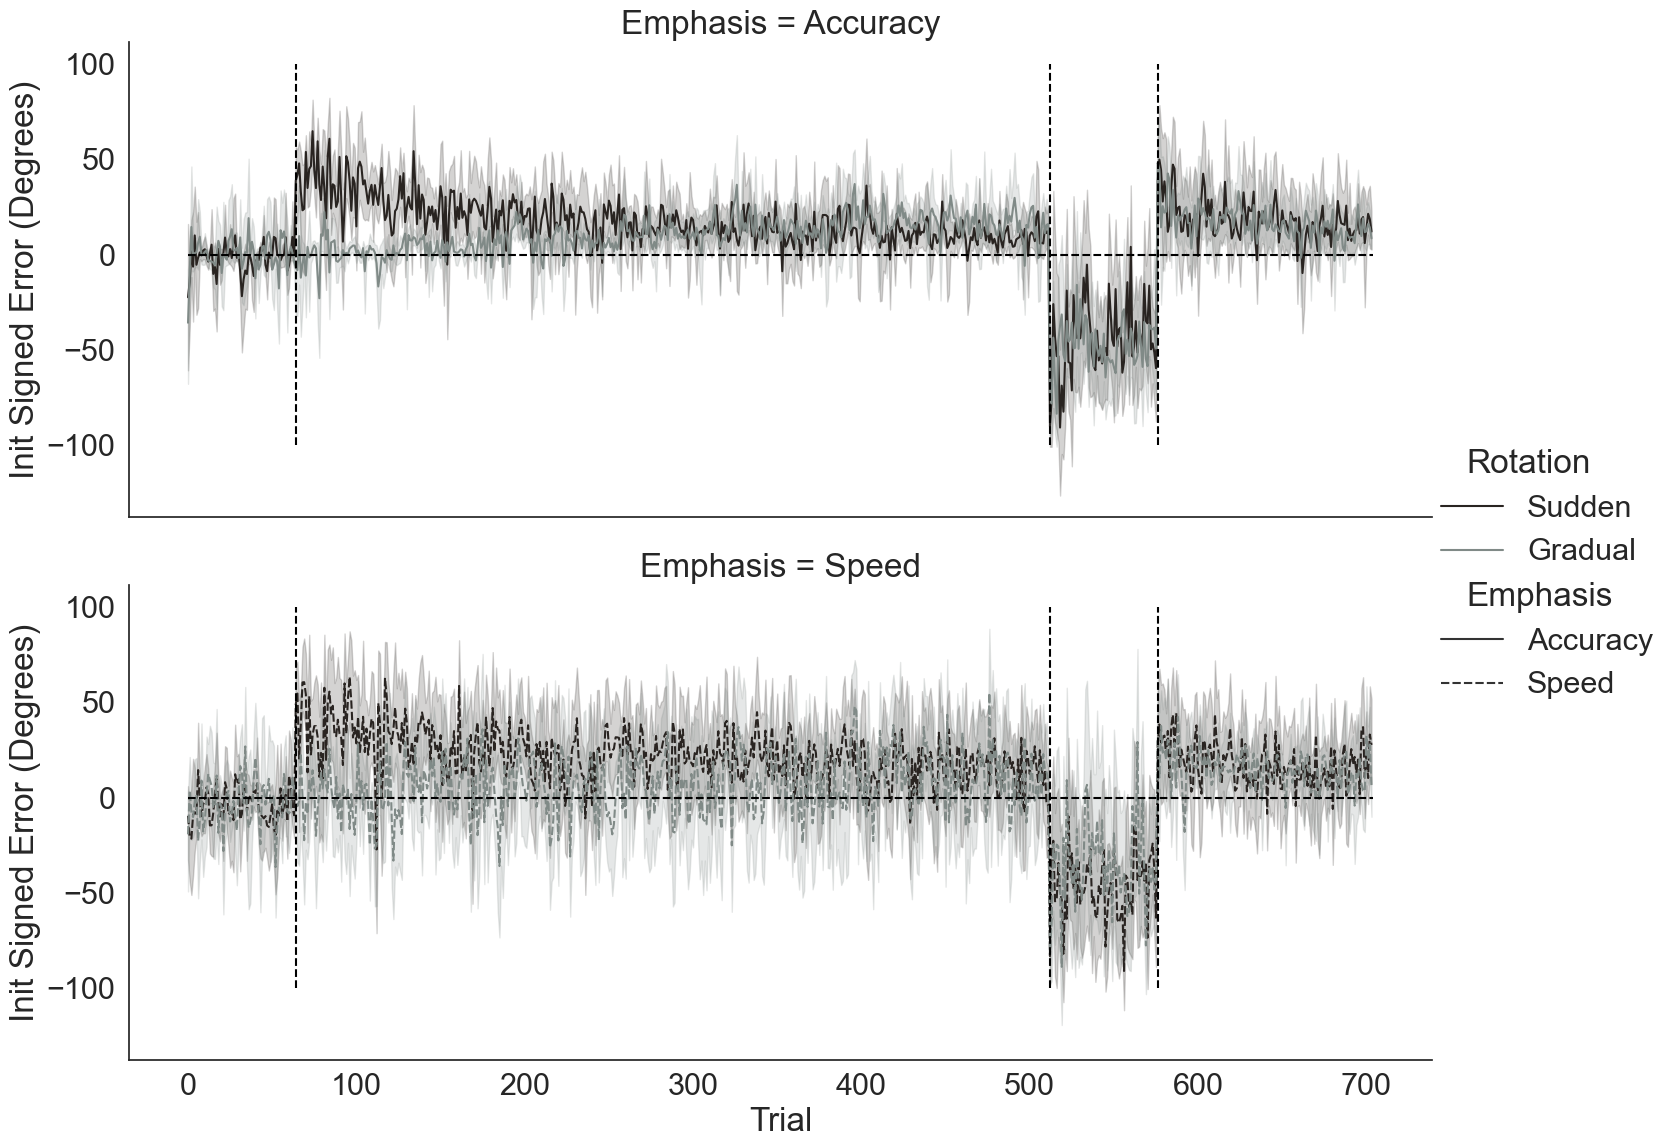

In [10]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial no', y = 'init signed errors degrees', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_allphases, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Init Signed Error (Degrees)')

# draw lines:
for ax in g.axes.ravel():
    ax.vlines(x = 64, ymax=100, ymin = -100, color = 'black', linestyles = '--')
    ax.vlines(x = 512, ymax=100, ymin = -100, color = 'black', linestyles = '--')
    ax.vlines(x = 576, ymax=100, ymin = -100, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 704, color = 'black', linestyles = '--')

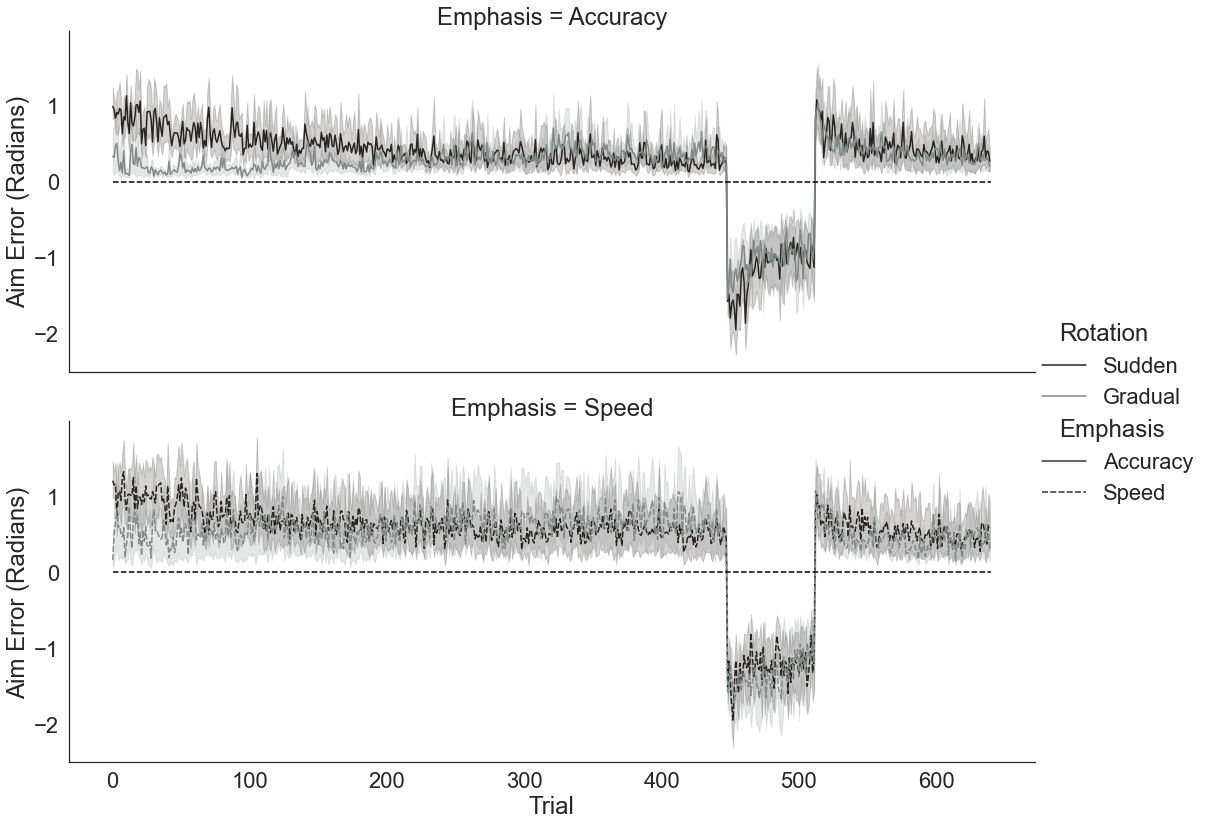

In [81]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))

g = sns.relplot(x = 'trial no', y = 'init errors', hue = 'Rotation', row = 'Emphasis', style='Emphasis', 
                 style_order=['Accuracy', 'Speed'], hue_order=['Sudden', 'Gradual'],
            data = df_allphases, height = 6, aspect = 2.5, kind = 'line')
g.set_axis_labels('Trial', 'Aim Error (Radians)')

# draw lines:
for ax in g.axes.ravel():
#     ax.vlines(x = 64, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
#     ax.vlines(x = 704, ymax=1.2, ymin = -0.1, color = 'black', linestyles = '--')
    ax.hlines(y=0, xmin = 0, xmax = 640, color = 'black', linestyles = '--')

Text(0.5, 1.0, 'Relearning Phase')

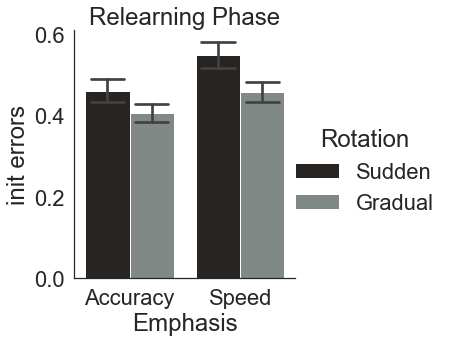

In [42]:
g = sns.catplot(x = 'Emphasis', y = 'init errors', hue = 'Rotation',   
                 hue_order=['Sudden', 'Gradual'],
            data = df_allphases.loc[df_allphases['phase'] == 'Relearning'], 
            kind = 'bar', capsize = 0.3)
plt.title('Relearning Phase')

In [44]:
df_allphases[['p_id', 'Rotation', 'Emphasis', 'phase', 'trial no', 'block no', 'avg errors', 'init errors', 'init signed errors']].to_csv('df_allphases.csv', index = False)

In [45]:
df_allphases = pd.read_csv('df_allphases.csv')
#Use data wrangler to compute and save blockwise 

,p_id,Rotation,Emphasis,phase,trial no,block no,avg errors,init errors
0,641,Gradual,Accuracy,Learning,0,0,0.276929,0.188780
1,641,Gradual,Accuracy,Learning,1,0,0.276929,0.188780
2,641,Gradual,Accuracy,Learning,2,0,0.146259,0.140401
3,641,Gradual,Accuracy,Learning,3,0,0.272961,0.291686
4,641,Gradual,Accuracy,Learning,4,0,0.588735,0.238112
...,...,...,...,...,...,...,...,...
39675,702,Sudden,Speed,Relearning,635,9,0.402465,1.203681
39676,702,Sudden,Speed,Relearning,636,9,0.827459,0.704598
39677,702,Sudden,Speed,Relearning,637,9,0.827459,0.704598
39678,702,Sudden,Speed,Relearning,638,9,0.715479,1.933589


In [46]:
df_allphases_blockwise = pd.read_csv('df_allphases_blockwise.csv')

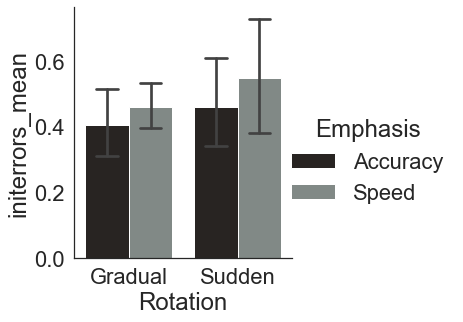

In [47]:
sns.catplot(y = 'initerrors_mean', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['phase'] == 'Relearning'))], 
            kind = 'bar', capsize = 0.2)

In [50]:
df_allphases_blockwise['difference'] = df_allphases_blockwise['initsignederrors_mean'].diff(periods= 2)

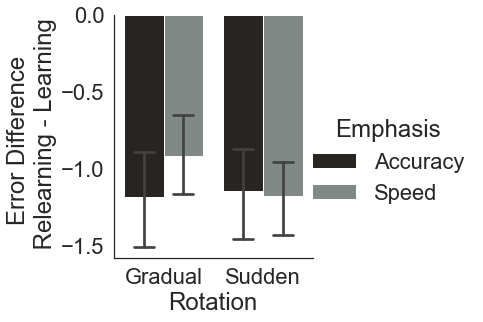

In [51]:
g = sns.catplot(y = 'difference', x = 'Rotation', hue = 'Emphasis', 
            data = df_allphases_blockwise.loc[((df_allphases_blockwise['block no'] == 8))], 
            kind = 'bar', capsize = 0.2)
g.set_ylabels('Error Difference \n Relearning - Learning')


# First three aiming plots

In [72]:
def clean_data_aim(df):
    # Drop columns: 'repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN' and 281 other columns
    df = df.drop(columns=['repeat_instructions.thisRepN', 'repeat_instructions.thisTrialN', 'repeat_instructions.thisN', 'repeat_instructions.thisIndex', 'accuracy_instructions.thisRepN', 'accuracy_instructions.thisTrialN', 'accuracy_instructions.thisN', 'accuracy_instructions.thisIndex', 'speed_instructions.thisRepN', 'speed_instructions.thisTrialN', 'speed_instructions.thisN', 'speed_instructions.thisIndex', 'baseline_trials.thisRepN', 'baseline_trials.thisTrialN', 'baseline_trials.thisN', 'baseline_trials.thisIndex', 'rotated_blocks.thisRepN', 'rotated_blocks.thisTrialN', 'rotated_blocks.thisN', 'rotated_blocks.thisIndex', 'rotated_trials.thisRepN', 'rotated_trials.thisTrialN', 'rotated_trials.thisN', 'rotated_trials.thisIndex', 'unlearning_trials.thisTrialN', 'unlearning_trials.thisN', 'unlearning_trials.thisIndex', 'relearning_blocks.thisRepN', 'relearning_blocks.thisTrialN', 'relearning_blocks.thisN', 'relearning_blocks.thisIndex', 'relearning_trials.thisRepN', 'relearning_trials.thisTrialN', 'relearning_trials.thisN', 'relearning_trials.thisIndex', 'instr_adv_mouse_0.started', 'instr_adv_text_0.started', 'instr_adv_mouse_0.x', 'instr_adv_mouse_0.y', 'instr_adv_mouse_0.leftButton', 'instr_adv_mouse_0.midButton', 'instr_adv_mouse_0.rightButton', 'instr_adv_mouse_0.time', 'consent0.started', 'consent_text0.started', 'consent0_keyresp.started', 'consent0_keyresp.keys', 'consent0_keyresp.rt', 'consent_text1.started', 'consent1.started', 'consent1_keyresp.started', 'consent1_keyresp.keys', 'consent1_keyresp.rt', 'consent2.started', 'consent_text2.started', 'consent2_keyresp.started', 'consent2_keyresp.keys', 'consent2_keyresp.rt', 'consent_text3.started', 'consent3_keyresp.started', 'consent3.started', 'consent3_keyresp.keys', 'consent3_keyresp.rt', 'consent_text4.started', 'consent4_keyresp.started', 'consent4.started', 'consent4_keyresp.keys', 'consent4_keyresp.rt', 'agree.started', 'disagree.started', 'consent5.started', 'agree.numClicks', 'agree.timesOn', 'agree.timesOff', 'disagree.numClicks', 'disagree.timesOn', 'disagree.timesOff', 'age.started', 'respAge.started', 'gender.started', 'genderResp2.started', 'nextButton.started', 'mouse.started', 'respAge.response', 'respAge.rt', 'genderResp2.text', 'mouse.x', 'mouse.y', 'mouse.leftButton', 'mouse.midButton', 'mouse.rightButton', 'mouse.clicked_name', 'instr_adv_mouse_05.started', 'instr_adv_text_05.started', 'instr_adv_mouse_05.x', 'instr_adv_mouse_05.y', 'instr_adv_mouse_05.leftButton', 'instr_adv_mouse_05.midButton', 'instr_adv_mouse_05.rightButton', 'instr_adv_mouse_05.time', 'instr_adv_text_1.started', 'instr_adv_mouse_1.started', 'instr_adv_mouse_1.x', 'instr_adv_mouse_1.y', 'instr_adv_mouse_1.leftButton', 'instr_adv_mouse_1.midButton', 'instr_adv_mouse_1.rightButton', 'instr_adv_mouse_1.time', 'instr_adv_text_2.started', 'instr_adv_mouse_2.started', 'instr_adv_mouse_2.x', 'instr_adv_mouse_2.y', 'instr_adv_mouse_2.leftButton', 'instr_adv_mouse_2.midButton', 'instr_adv_mouse_2.rightButton', 'instr_adv_mouse_2.time', 'instr_acc_adv_text_3.started', 'instr_adv_mouse_3_acc.started', 'instr_adv_mouse_3_acc.x', 'instr_adv_mouse_3_acc.y', 'instr_adv_mouse_3_acc.leftButton', 'instr_adv_mouse_3_acc.midButton', 'instr_adv_mouse_3_acc.rightButton', 'instr_adv_mouse_3_acc.time', 'repeat_instructions_text.started', 'repeat_instr_adv.started', 'repeat_instr_repeat.started', 'repeat_instr_adv.x', 'repeat_instr_adv.y', 'repeat_instr_adv.leftButton', 'repeat_instr_adv.midButton', 'repeat_instr_adv.rightButton', 'repeat_instr_adv.time', 'repeat_instr_repeat.keys', 'text_countdown_2.started', 'cursor.started', 'cursor.stopped', 'target_baseline.started', 'mouse_baseline.started', 'cursor_baseline.started', 'target_baseline.stopped', 'mouse_baseline.stopped', 'cursor_baseline.stopped', 'mouse_baseline.x', 'mouse_baseline.y', 'mouse_baseline.leftButton', 'mouse_baseline.midButton', 'mouse_baseline.rightButton', 'mouse_baseline.time', 'mouse_baseline.clicked_name', 'break_text.started', 'break_mouse.started', 'improve_text.started', 'break_mouse.x', 'break_mouse.y', 'break_mouse.leftButton', 'break_mouse.midButton', 'break_mouse.rightButton', 'break_mouse.time', 'target_rotated.started', 'mouse_rotated.started', 'cursor_rotated.started', 'mouse_rotated.x', 'mouse_rotated.y', 'mouse_rotated.leftButton', 'mouse_rotated.midButton', 'mouse_rotated.rightButton', 'mouse_rotated.time', 'instr_adv_text_4.started', 'instr_adv_mouse_4.started', 'instr_adv_mouse_4.x', 'instr_adv_mouse_4.y', 'instr_adv_mouse_4.leftButton', 'instr_adv_mouse_4.midButton', 'instr_adv_mouse_4.rightButton', 'instr_adv_mouse_4.time', 'instr_adv_text_5.started', 'instr_adv_mouse_5.started', 'instr_adv_mouse_5.x', 'instr_adv_mouse_5.y', 'instr_adv_mouse_5.leftButton', 'instr_adv_mouse_5.midButton', 'instr_adv_mouse_5.rightButton', 'instr_adv_mouse_5.time', 'instr_adv_text_55.started', 'instr_adv_mouse_55.started', 'instr_adv_mouse_55.x', 'instr_adv_mouse_55.y', 'instr_adv_mouse_55.leftButton', 'instr_adv_mouse_55.midButton', 'instr_adv_mouse_55.rightButton', 'instr_adv_mouse_55.time', 'phase_cntdown.started', 'target_aiming.started', 'aim_typing_instruction.started', 'end_routine_instruction.started', 'aim_cursor.started', 'aim_report_end.started', 'aim_report_end.keys', 'aim_report_end.rt', 'target_swiping.started', 'swipe_cursor.started', 'aim_swipe_mouse.started', 'swiping_trial_instuctions.started', 'aim_swipe_mouse.leftButton', 'aim_swipe_mouse.midButton', 'aim_swipe_mouse.rightButton', 'aim_swipe_mouse.time', 'text.started', 'text.stopped', 'instr_adv_text_6.started', 'instr_adv_mouse_6.started', 'instr_adv_mouse_6.x', 'instr_adv_mouse_6.y', 'instr_adv_mouse_6.leftButton', 'instr_adv_mouse_6.midButton', 'instr_adv_mouse_6.rightButton', 'instr_adv_mouse_6.time', 'target_unlearning.started', 'mouse_unlearning.started', 'cursor_unlearning.started', 'mouse_unlearning.x', 'mouse_unlearning.y', 'mouse_unlearning.leftButton', 'mouse_unlearning.midButton', 'mouse_unlearning.rightButton', 'mouse_unlearning.time', 'no_score_break_text.started', 'no_score_break_mouse.started', 'no_score_break_mouse.x', 'no_score_break_mouse.y', 'no_score_break_mouse.leftButton', 'no_score_break_mouse.midButton', 'no_score_break_mouse.rightButton', 'no_score_break_mouse.time', 'study_done.started', 'study_done_mouse.started', 'thoughts_on_study.started', 'study_done_adv.started', 'study_done_mouse.x', 'study_done_mouse.y', 'study_done_mouse.leftButton', 'study_done_mouse.midButton', 'study_done_mouse.rightButton', 'study_done_mouse.time', 'thoughts_on_study.text', 'pre_debrief_text.started', 'pre_debrief_mouse.started', 'pre_debrief_mouse.x', 'pre_debrief_mouse.y', 'pre_debrief_mouse.leftButton', 'pre_debrief_mouse.midButton', 'pre_debrief_mouse.rightButton', 'pre_debrief_mouse.time', 'debrief_text.started', 'debrief_mouse.started', 'debrief_mouse.x', 'debrief_mouse.y', 'debrief_mouse.leftButton', 'debrief_mouse.midButton', 'debrief_mouse.rightButton', 'debrief_mouse.time', 'text_countdown.started', 'participant', 'date', 'expName', 'psychopyVersion', 'frameRate', 'Unnamed: 280', 'instr_spd_adv_text_3.started', 'instr_adv_mouse_3_spd.started', 'instr_adv_mouse_3_spd.x', 'instr_adv_mouse_3_spd.y', 'instr_adv_mouse_3_spd.leftButton', 'instr_adv_mouse_3_spd.midButton', 'instr_adv_mouse_3_spd.rightButton', 'instr_adv_mouse_3_spd.time', 'phase_cntdown.stopped', 'Unnamed: 281', 'repeat_instr_repeat.rt', 'Unnamed: 282', 'unlearning_trials.thisRepN', 'aim_report_text.started'])
    # Filter rows based on column: 'aim_swipe_mouse.x'
    df = df[df['aim_swipe_mouse.x'].notna()]
    # Filter rows based on column: 'aim report'
    df = df[df['aim report'].notna()]
    # Drop column: 'aim_report_text.text'
    # df = df.drop(columns=['aim_report_text.text'])
    # Drop column: 'cursor trajectory'
    df = df.drop(columns=['cursor trajectory'])
    return df

df_aim = clean_data_aim(df.copy()).reset_index().drop('index', axis = 1)
# df_aim.head()

In [73]:
df_aim['aim report'] = df_aim['aim report']*4
df_aim['trial'] = np.tile(np.arange(16), 62)
df_aim.loc[df_aim['p_id']%2 == 0, 'Rotation'] = 'Sudden'
df_aim.loc[df_aim['p_id']%2 == 1, 'Rotation'] = 'Gradual'

df_aim.loc[df_aim['p_id']%4 == 0, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 1, 'Emphasis'] = 'Accuracy'
df_aim.loc[df_aim['p_id']%4 == 2, 'Emphasis'] = 'Speed'
df_aim.loc[df_aim['p_id']%4 == 3, 'Emphasis'] = 'Speed'

df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 45
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == 0.3)), 'target angle'] = 135
df_aim.loc[((df_aim['target_x'] == -0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 225
df_aim.loc[((df_aim['target_x'] == 0.3) & (df_aim['target_y'] == -0.3)), 'target angle'] = 315

df_aim['optimal report'] = df_aim['target angle'] - 60
df_aim.loc[df_aim['optimal report'] < 0, 'optimal report'] = 360-15
df_aim['optimal report - report'] = df_aim['optimal report'] - df_aim['aim report']

df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report'] = 360 - df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report']
df_aim.loc[df_aim['optimal report - report'] < -180, 'optimal report - report'] = -360 - df_aim.loc[df_aim['optimal report - report'] > 180, 'optimal report - report']



In [74]:
def find_aim_angles(a, b, c):

  # Calculate the vectors ab and ac for each triplet of points.
  ab = a - b
  ac = a - c
  angles = []
  dotprod = np.dot(ab, ac)
  ab_magnitudes = np.linalg.norm(ab)
  ac_magnitudes = np.linalg.norm(ac)
  # print(dot_products.shape)
  # Calculate the angles between ab and ac.
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))

  return np.degrees(angles)

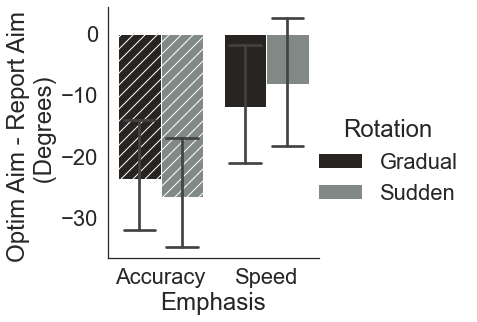

In [75]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'optimal report - report', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Optim Aim - Report Aim \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [62]:
aim_swipe_error = []
swipe_angles = []
for i in range(len(df_aim)):
    x_target = df_aim.loc[i, 'target_x']
    y_target = df_aim.loc[i, 'target_y']
    x_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.x'])[-1]
    y_end = ast.literal_eval(df_aim.loc[i, 'aim_swipe_mouse.y'])[-1]
    swipe_angle = find_aim_angles(np.array([0, 0]), np.array([1, 0]), np.array([x_end, y_end]))

    report_angle = df_aim.loc[i, 'aim report']
    aim_swipe_error.append((report_angle - swipe_angle))
    swipe_angles.append(swipe_angle)
    
df_aim['aim report - swipe'] = aim_swipe_error
# df_aim['swipe angle'] = swipe_angles

# df_aim['optimal report - swipe'] = df_aim['optimal report'] - (df_aim['aim report'] - df_aim['aim report - swipe'])

C:\Users\tejas\AppData\Local\Temp\ipykernel_10036\173691674.py:12: RuntimeWarning: invalid value encountered in double_scalars
  angles = np.arccos(dotprod / (ab_magnitudes * ac_magnitudes))


In [67]:
df_aim['swipe angle'] = swipe_angles

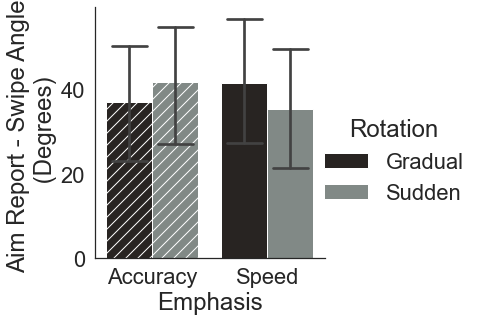

In [65]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'aim report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Aim Report - Swipe Angle \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])


In [69]:
df_aim['optimal report - swipe'] = df_aim['optimal report'] - df_aim['swipe angle']

df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe'] = 360 - df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe']
df_aim.loc[df_aim['optimal report - swipe'] < -180, 'optimal report - swipe'] = -360 - df_aim.loc[df_aim['optimal report - swipe'] > 180, 'optimal report - swipe']


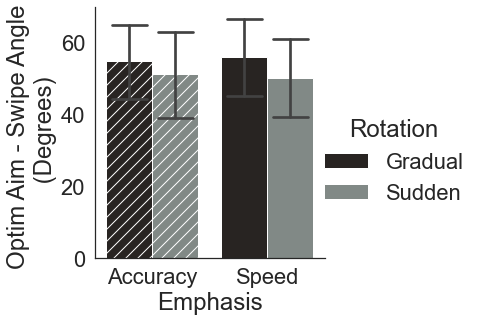

In [70]:
sns.set_context('talk')
sns.set(font_scale = 2)
sns.set_style('white')
colors = [ '#292421', '#808A87']
sns.set_palette(sns.color_palette(colors))


g = sns.catplot(y = 'optimal report - swipe', x = 'Emphasis', hue = 'Rotation',
            kind = 'bar', capsize = 0.3,
            data=df_aim)

x1, x2 = 0, 1
g.set(ylabel='Optim Aim - Swipe Angle \n (Degrees)')
g.set(title=None)

# g.set_yl
hatches = ['//', '', '//', '']
for ax in g.axes.flat:
    patches = [patch for patch in ax.patches]
    for i, patch in enumerate(patches):
        patch.set_hatch(hatches[i])
